In [4]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap,addcyclic,shiftgrid
from scipy.stats import t
from scipy import stats
import sys
import os

In [5]:
iyr=1850 #initial year
fyr=2014 #final year 
nyr=fyr-iyr+1 # number of year
#Season/month
season='annual'
imon=1
fmon=12
#Region
domain='global'
#Model and variable
model='IPSL-CM6A-LR'
variable='tas'
##Number of members
member='r1i1p1f1'
#member='ensmean'

In [6]:
fh = Dataset('./tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc', mode = 'r')
#fh = Dataset('./tas_Amon_IPSL-CM6A-LR_historical_emi1p1f1_gr_185001-201412.nc', mode = 'r')
field0= fh.variables['tas'][:] 
units=fh.variables['tas'].units
xlon0 = fh.variables['lon'][:]
##Shifting longitude from 0 to 360 to -180 to 180
##https://matplotlib.org/basemap/api/basemap_api.html
field,xlon = shiftgrid(180., field0, xlon0, start=False)
nlon=len(xlon)
ylat = fh.variables['lat'][:]
nlat=len(ylat)
time=fh.variables['time']
fh.close()

In [7]:
%reset_selective -f field0

In [8]:
field=field[(12*(iyr-1850)):(12*(fyr+1-1850)),:,:]

In [9]:
value=np.zeros((nyr,nlat,nlon))
for i in range(nyr):
    tmp=field[12*i+(imon-1):12*i+(fmon),:,:]
    value[i,:,:]=np.mean(tmp,axis=0)

In [10]:
%reset_selective -f field

In [11]:
#clim=np.zeros((nlat,nlon))
clim=np.ma.mean(value,axis=0)  
#std=np.ma.std(value,axis=0)

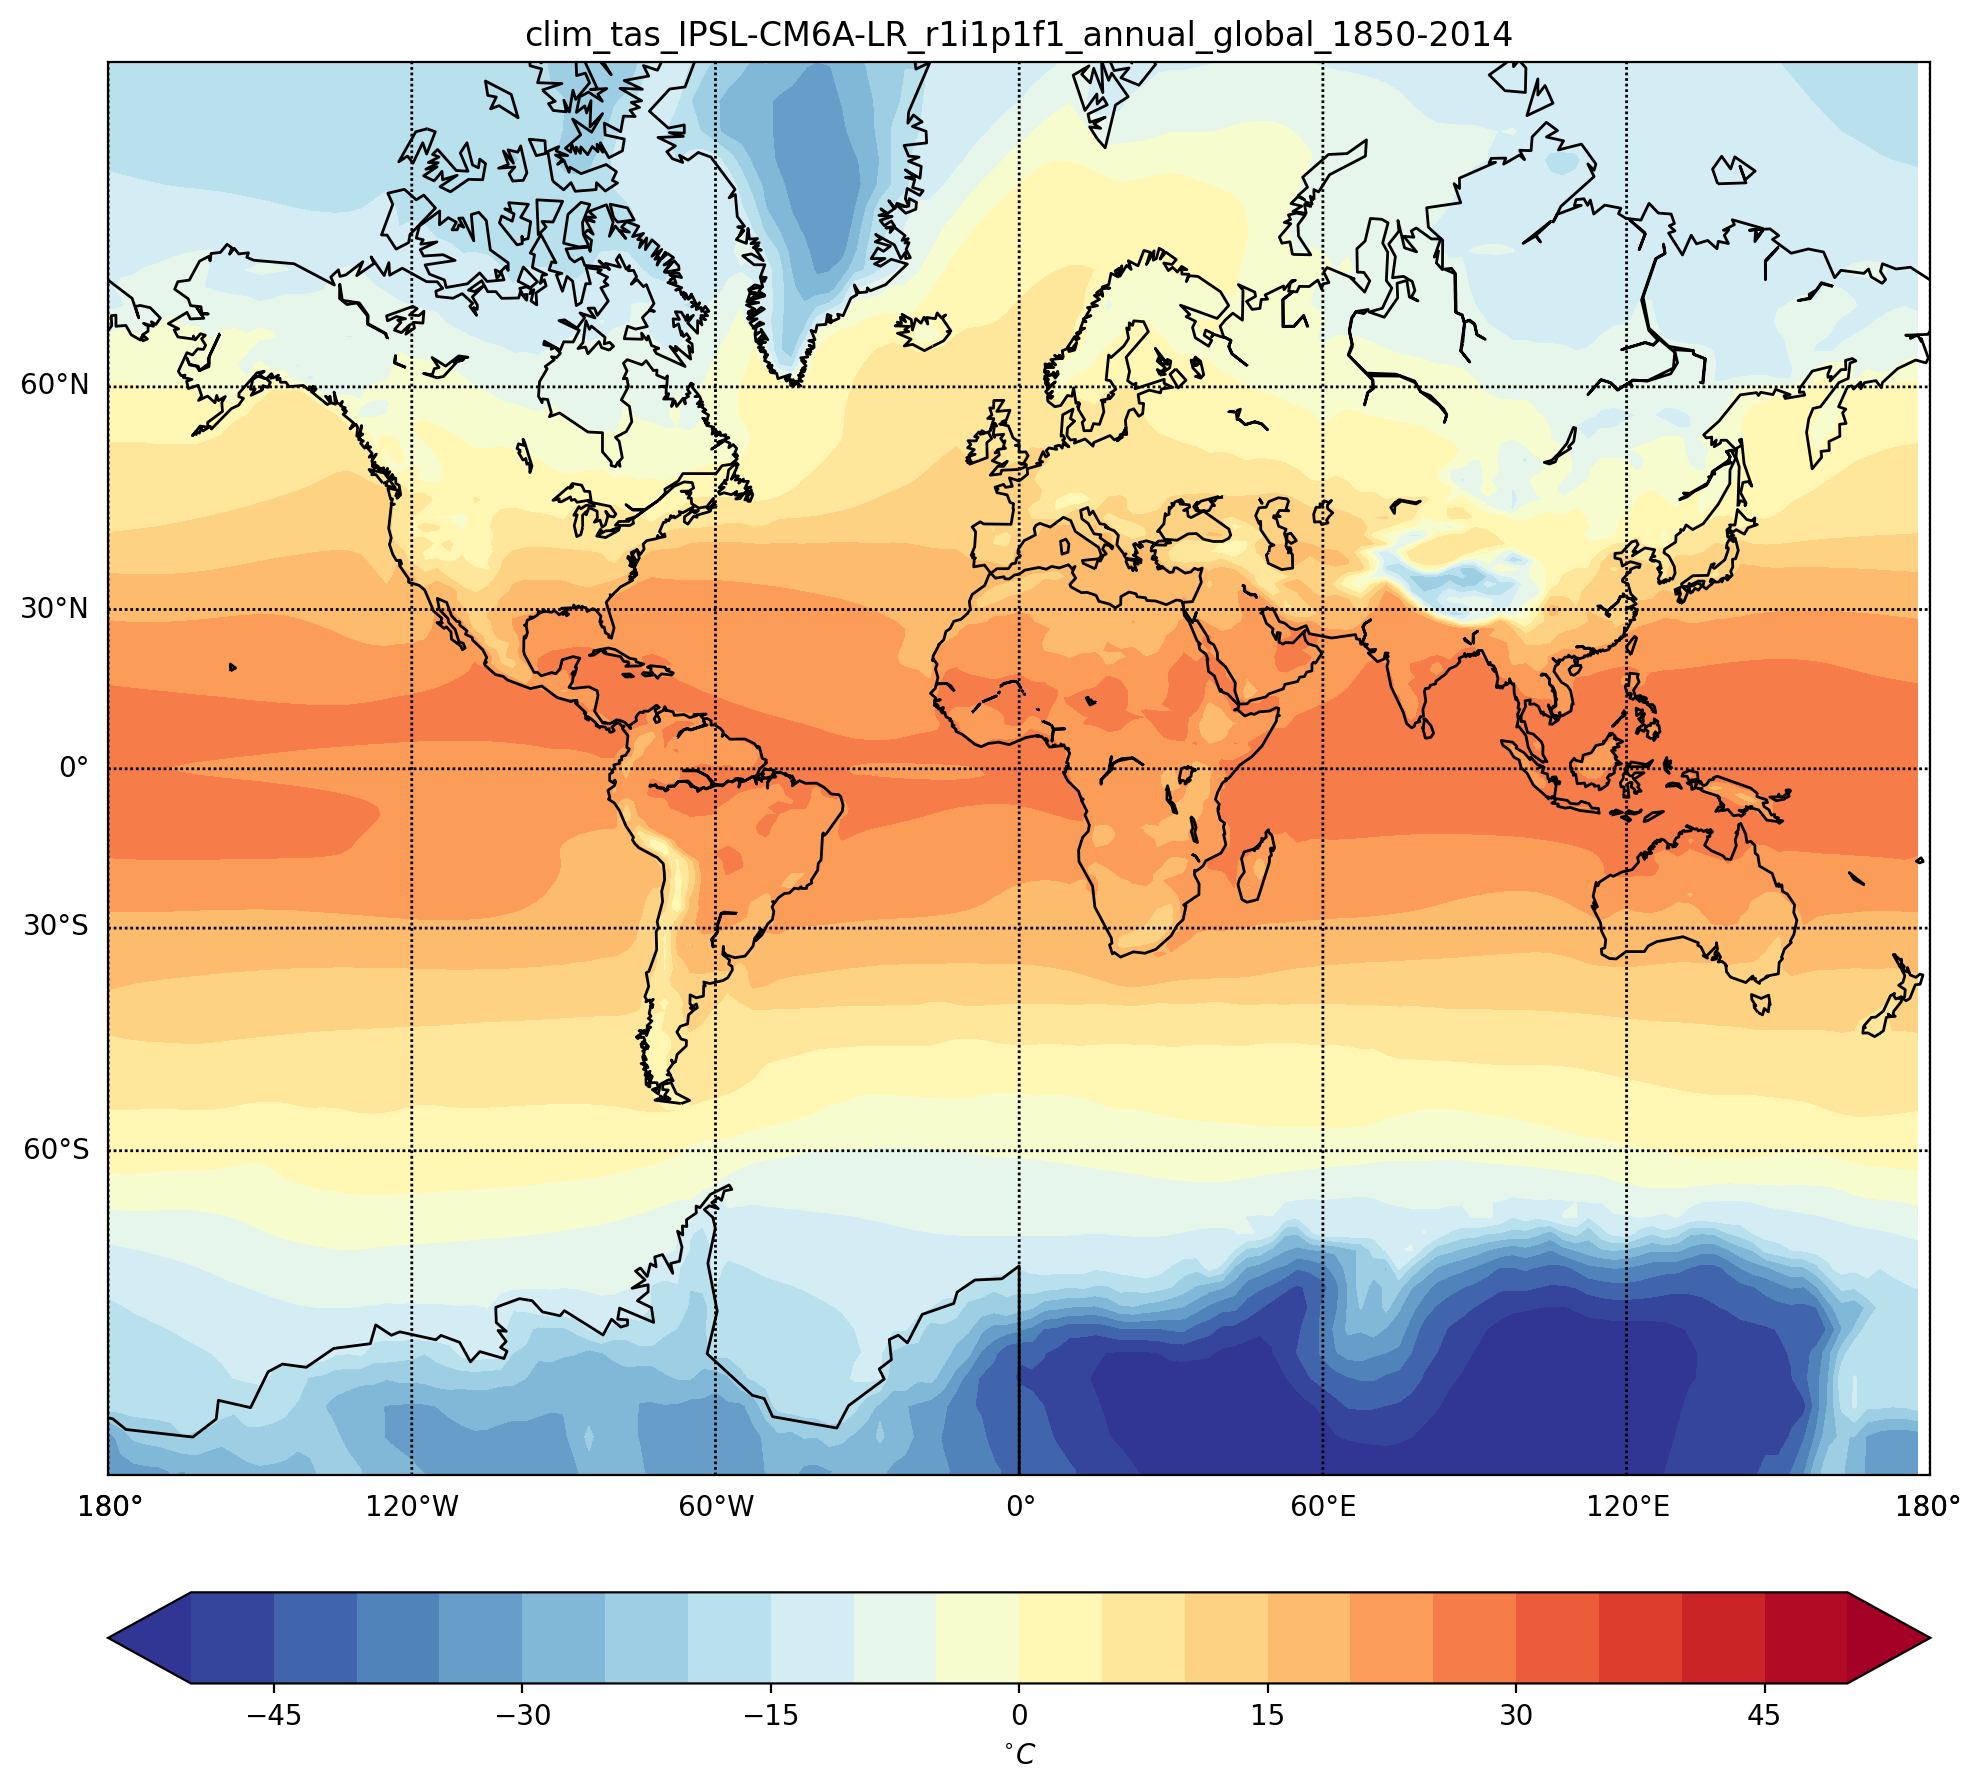

In [12]:
fig=plt.figure(figsize=(10,12))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
lons, lats = np.meshgrid(xlon,ylat)
clevs=np.arange(-50,55,5)
cmap=plt.cm.RdYlBu_r
CS1 = m.contourf(lons,lats,clim[:,:]-273.15,clevs,cmap=cmap,latlon=True,extend='both')
cb = fig.colorbar(CS1,orientation="horizontal", pad=0.05)
cb.set_label('$^{\circ}C$', fontsize=10)
plotname='clim_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plt.title('%s'%(plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [11]:
print(lons)

[[-180.  -177.5 -175.  ...  172.5  175.   177.5]
 [-180.  -177.5 -175.  ...  172.5  175.   177.5]
 [-180.  -177.5 -175.  ...  172.5  175.   177.5]
 ...
 [-180.  -177.5 -175.  ...  172.5  175.   177.5]
 [-180.  -177.5 -175.  ...  172.5  175.   177.5]
 [-180.  -177.5 -175.  ...  172.5  175.   177.5]]


In [12]:
print(lats)

[[-90.      -90.      -90.      ... -90.      -90.      -90.     ]
 [-88.73239 -88.73239 -88.73239 ... -88.73239 -88.73239 -88.73239]
 [-87.46479 -87.46479 -87.46479 ... -87.46479 -87.46479 -87.46479]
 ...
 [ 87.46479  87.46479  87.46479 ...  87.46479  87.46479  87.46479]
 [ 88.73239  88.73239  88.73239 ...  88.73239  88.73239  88.73239]
 [ 90.       90.       90.      ...  90.       90.       90.     ]]


In [13]:
anom=np.zeros((nyr,nlat,nlon))
#anom=ma.masked_array(anom1,mask=field[0:nyr].mask)
for i in range(nyr):
    anom[i,:,:]=value[i,:,:]-clim

In [14]:
%reset_selective -f clim
%reset_selective -f value

In [15]:
deg=1
#deg=int(sys.argv[2])
anom_notrend=np.zeros((nyr,nlat,nlon))
xyears=np.arange(0,nyr,1)
for j in range(nlat):
    for i in range(nlon):
        if deg==1:
            poly=np.polyfit(xyears,anom[:,j,i],deg=1)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears+poly[1])
        elif deg==2:
            poly=np.polyfit(xyears,anom[:,j,i],deg=2)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**2+poly[1]*xyears+poly[2])
        elif deg==3:
            poly=np.polyfit(xyears,anom[:,j,i],deg=3)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**3+poly[1]*xyears**2+poly[2]*xyears+poly[3])

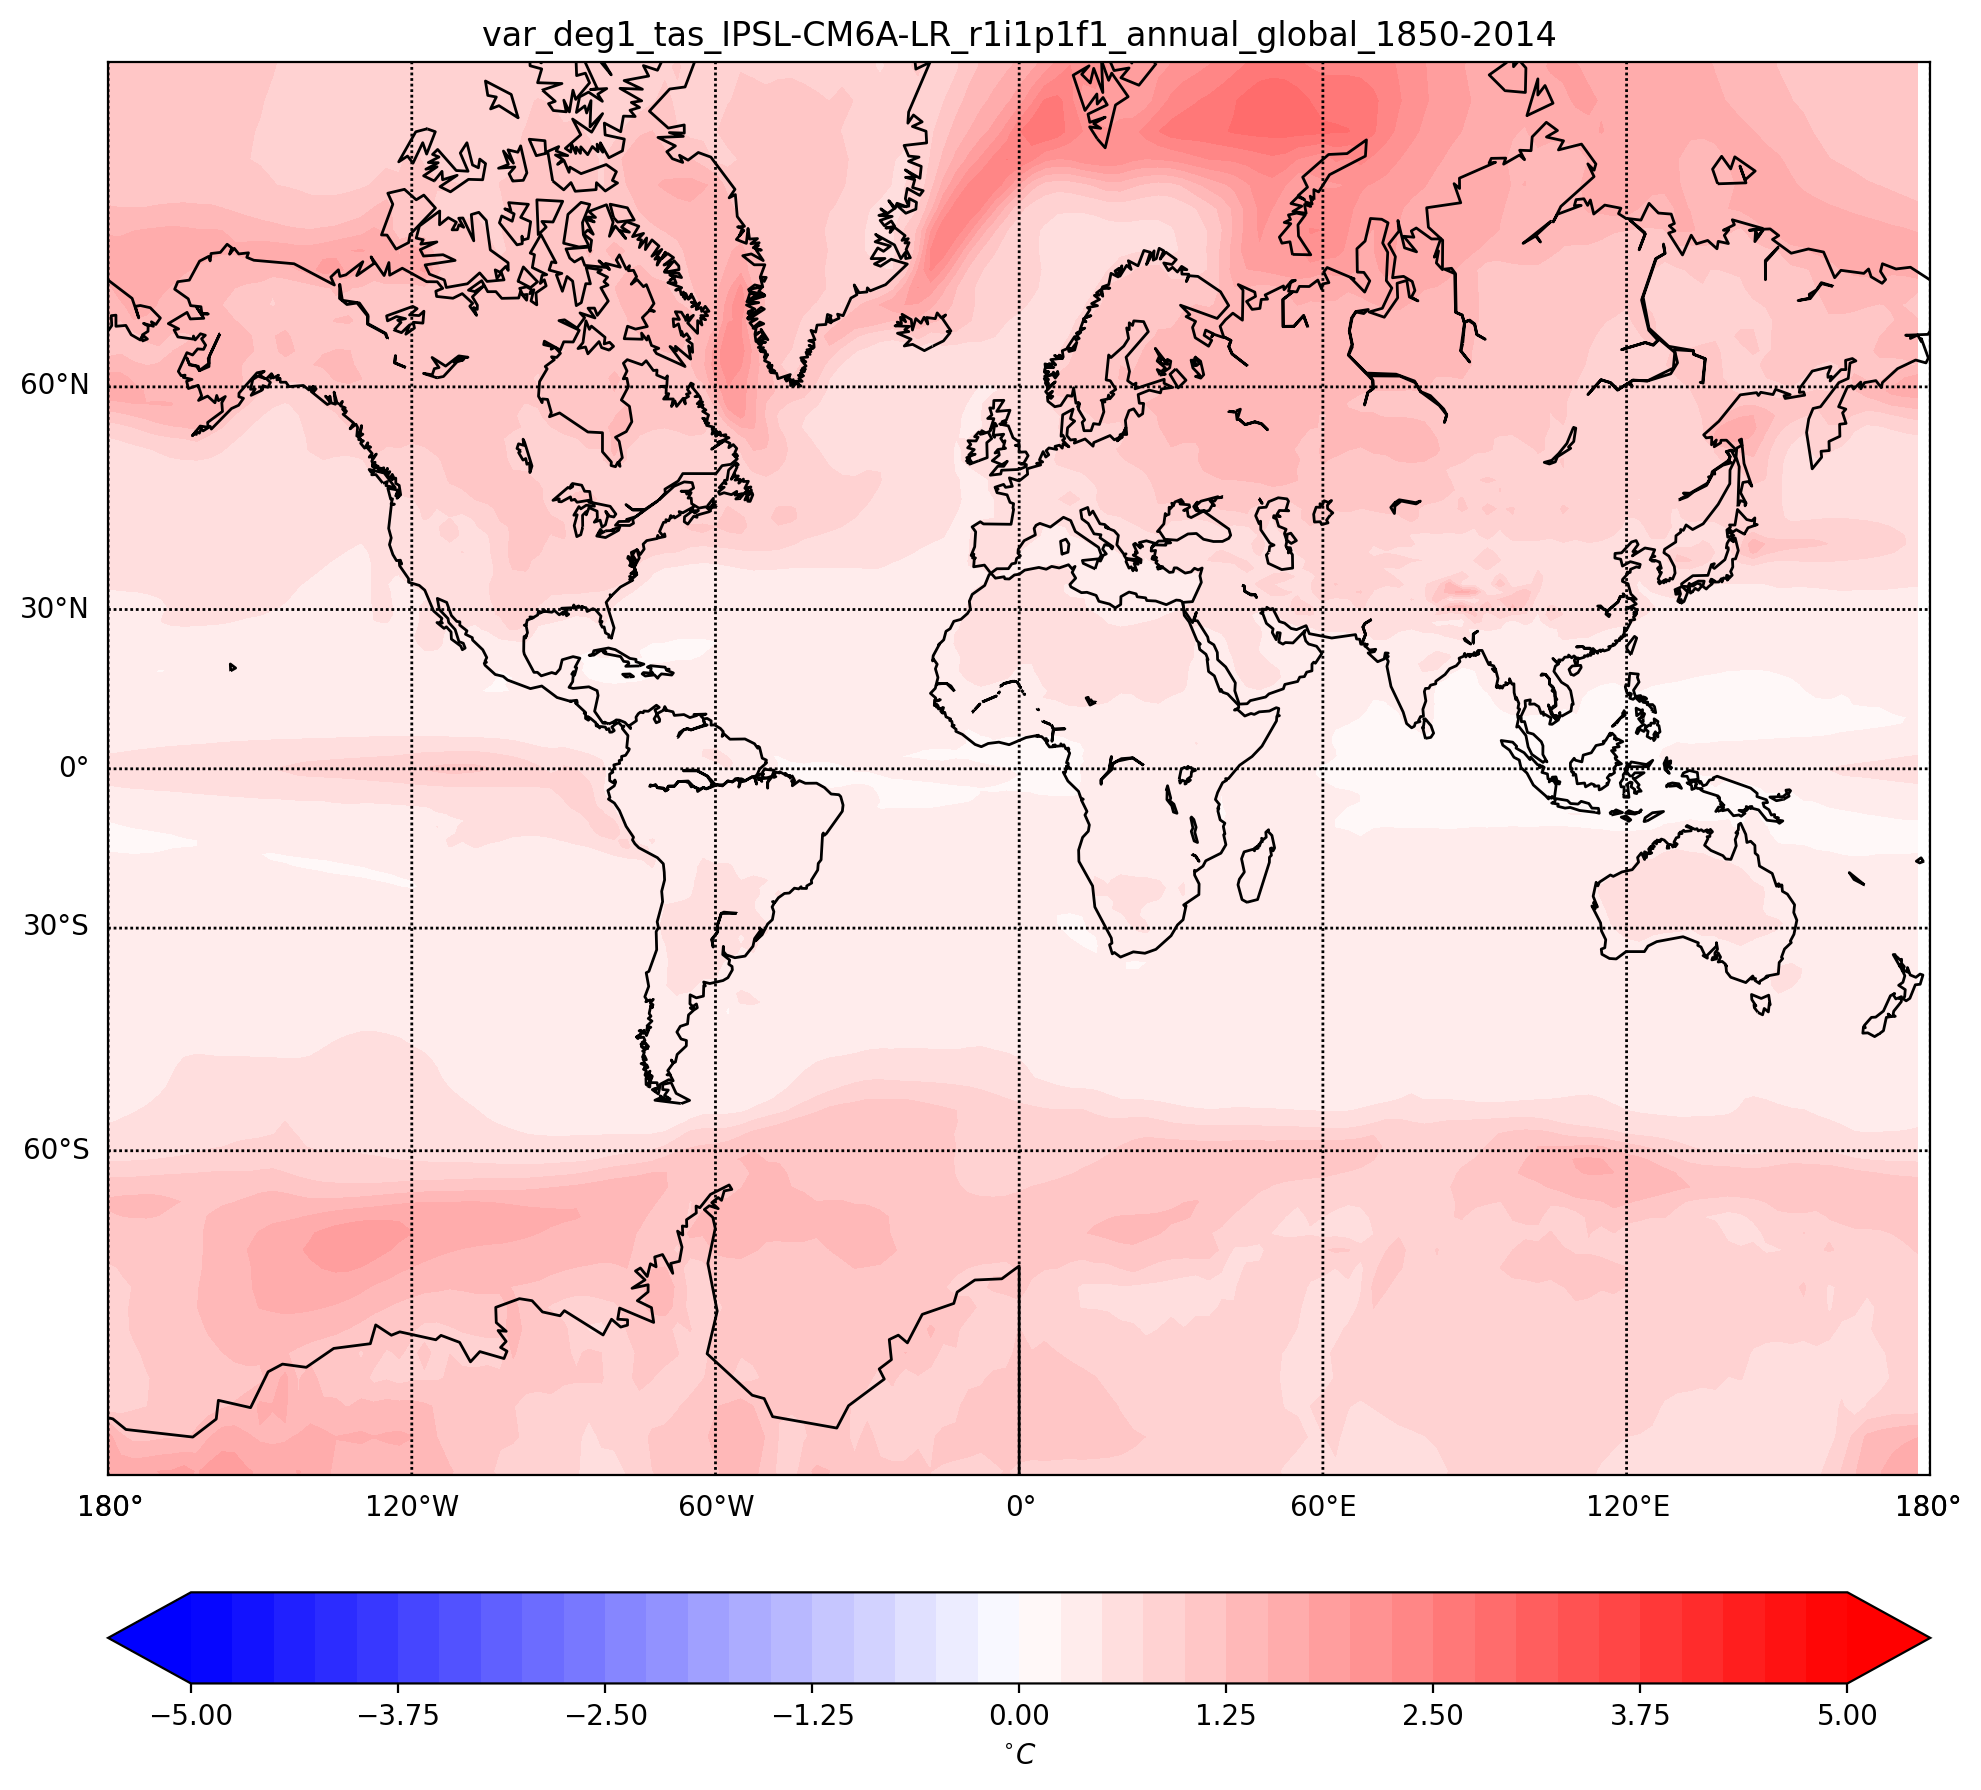

In [16]:
stdnotrend=np.ma.std(anom_notrend,axis=0)
###
##Plotting standard deviation of anomalies
###
fig=plt.figure(figsize=(10,12))

m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
lons, lats = np.meshgrid(xlon,ylat)
clevs=np.arange(-5,5.25,0.25)
cmap=plt.cm.bwr
CS1 = m.contourf(lons,lats,stdnotrend[:,:],clevs,cmap=cmap,latlon=True,extend='both')
cb = fig.colorbar(CS1,orientation="horizontal", pad=0.05)
cb.set_label('$^{\circ}C$', fontsize=10)
plotname='var_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,season,domain,iyr,fyr)
plt.title('%s'%(plotname), fontsize=12)
plt.tight_layout()
##plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [17]:
%reset_selective -f anom_notrend
%reset_selective -f stdnotrend

In [18]:
trend=np.empty((nlat,nlon))
#intercept=np.empty((nlat,nlon))
#pvalue=np.empty((nlat,nlon))
#rvalue=np.empty((nlat,nlon))
#stderr=np.empty((nlat,nlon))
xd=np.array(range((nyr)))

In [19]:
for j in range(nlat):
    for i in range(nlon):
        yd=anom[:,j,i]
        par = stats.linregress(xd, yd)
#        stderr[j,i]=par[4]
#        pvalue[j,i]=par[3]
#        rvalue[j,i]=par[2]
#        intercept[j,i]=par[1]
        trend[j,i]=par[0]

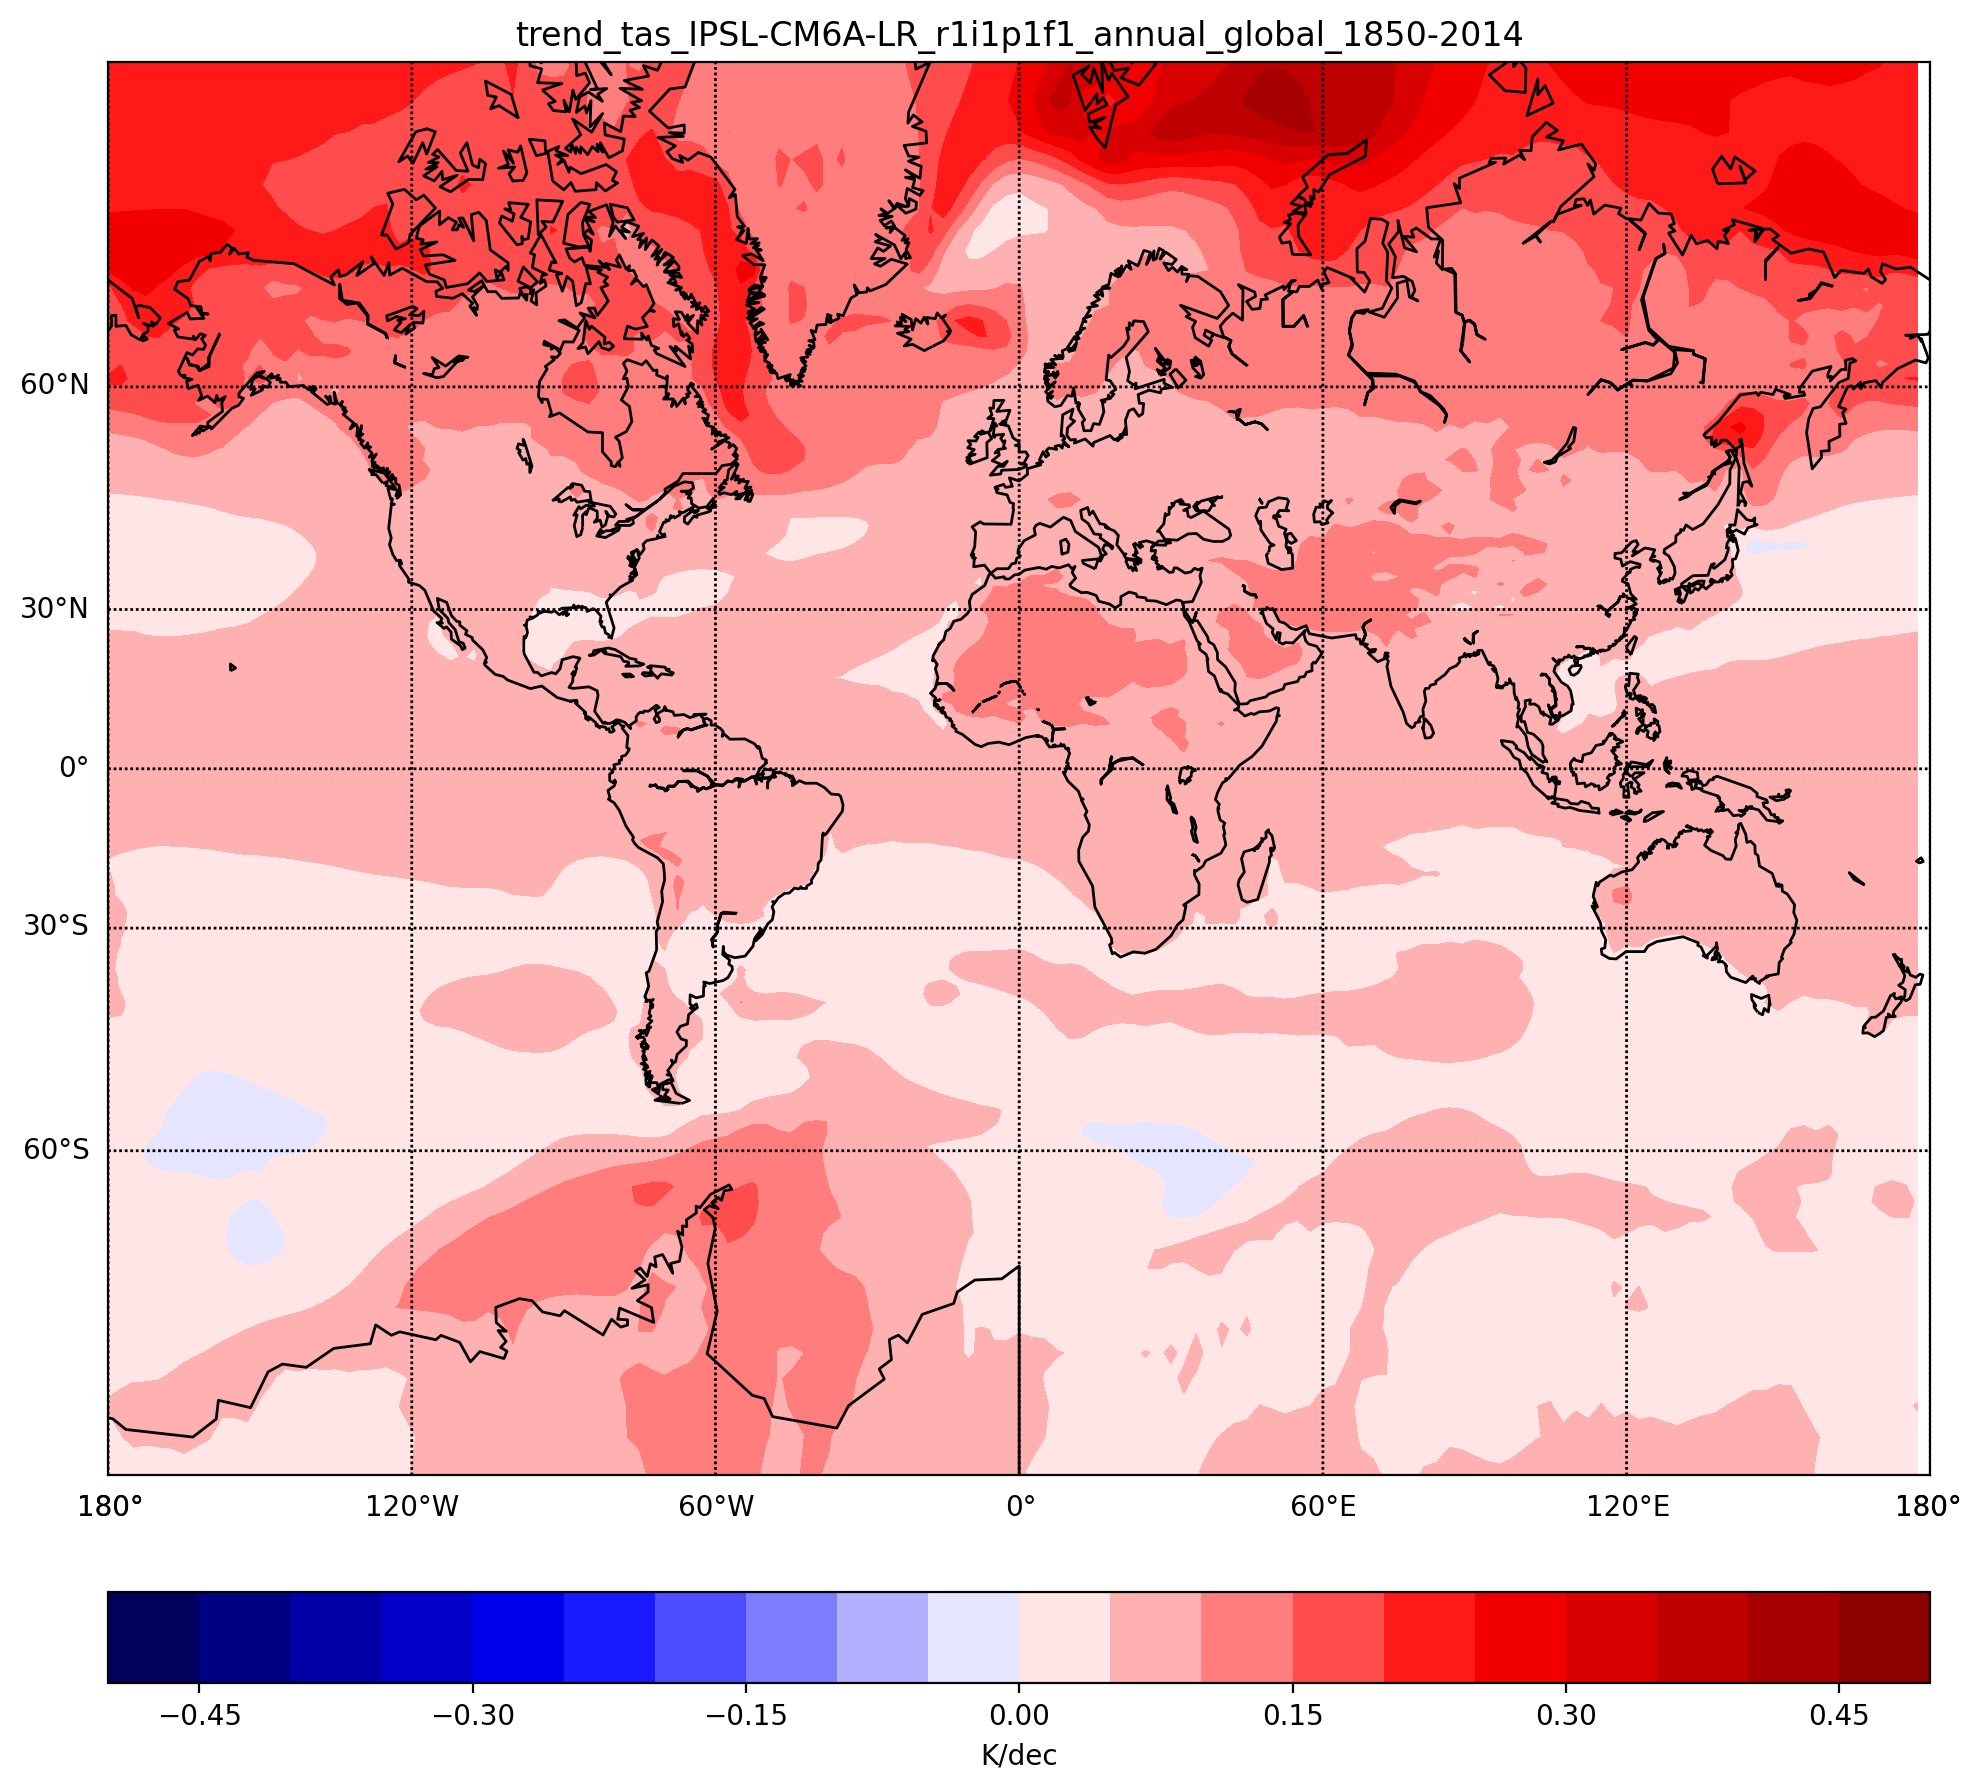

In [21]:
fig=plt.figure(figsize=(10,12))

m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
lons, lats = np.meshgrid(xlon,ylat)

clevs=np.arange(-0.5,0.55,0.05)
CS1=m.contourf(lons,lats,trend*10,clevs,cmap=plt.cm.seismic,latlon=True)
#levels=[0,0.1,1.0]
#cs = m.contourf(lons,lats,pvalue,levels=levels,hatches=["+", ""], alpha=0.,latlon=True)
cb = fig.colorbar(CS1,orientation="horizontal",pad=0.05)
cb.set_label('%s/dec'%(units), fontsize=10)
plotname='trend_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plt.title('%s'%(plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [23]:
domain='global'

wgts = np.cos(np.deg2rad(ylat))

ts_anoms=np.ma.average(np.ma.average(anom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
#ts_anoms_notrend=np.ma.average(np.ma.average(anom_notrend,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)

#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par = stats.linregress(xd,ts_anoms)
trend=par[0]
intercept=par[1]
#rvalue=par[2]
#pvalue=par[3]
#stderr=par[4]

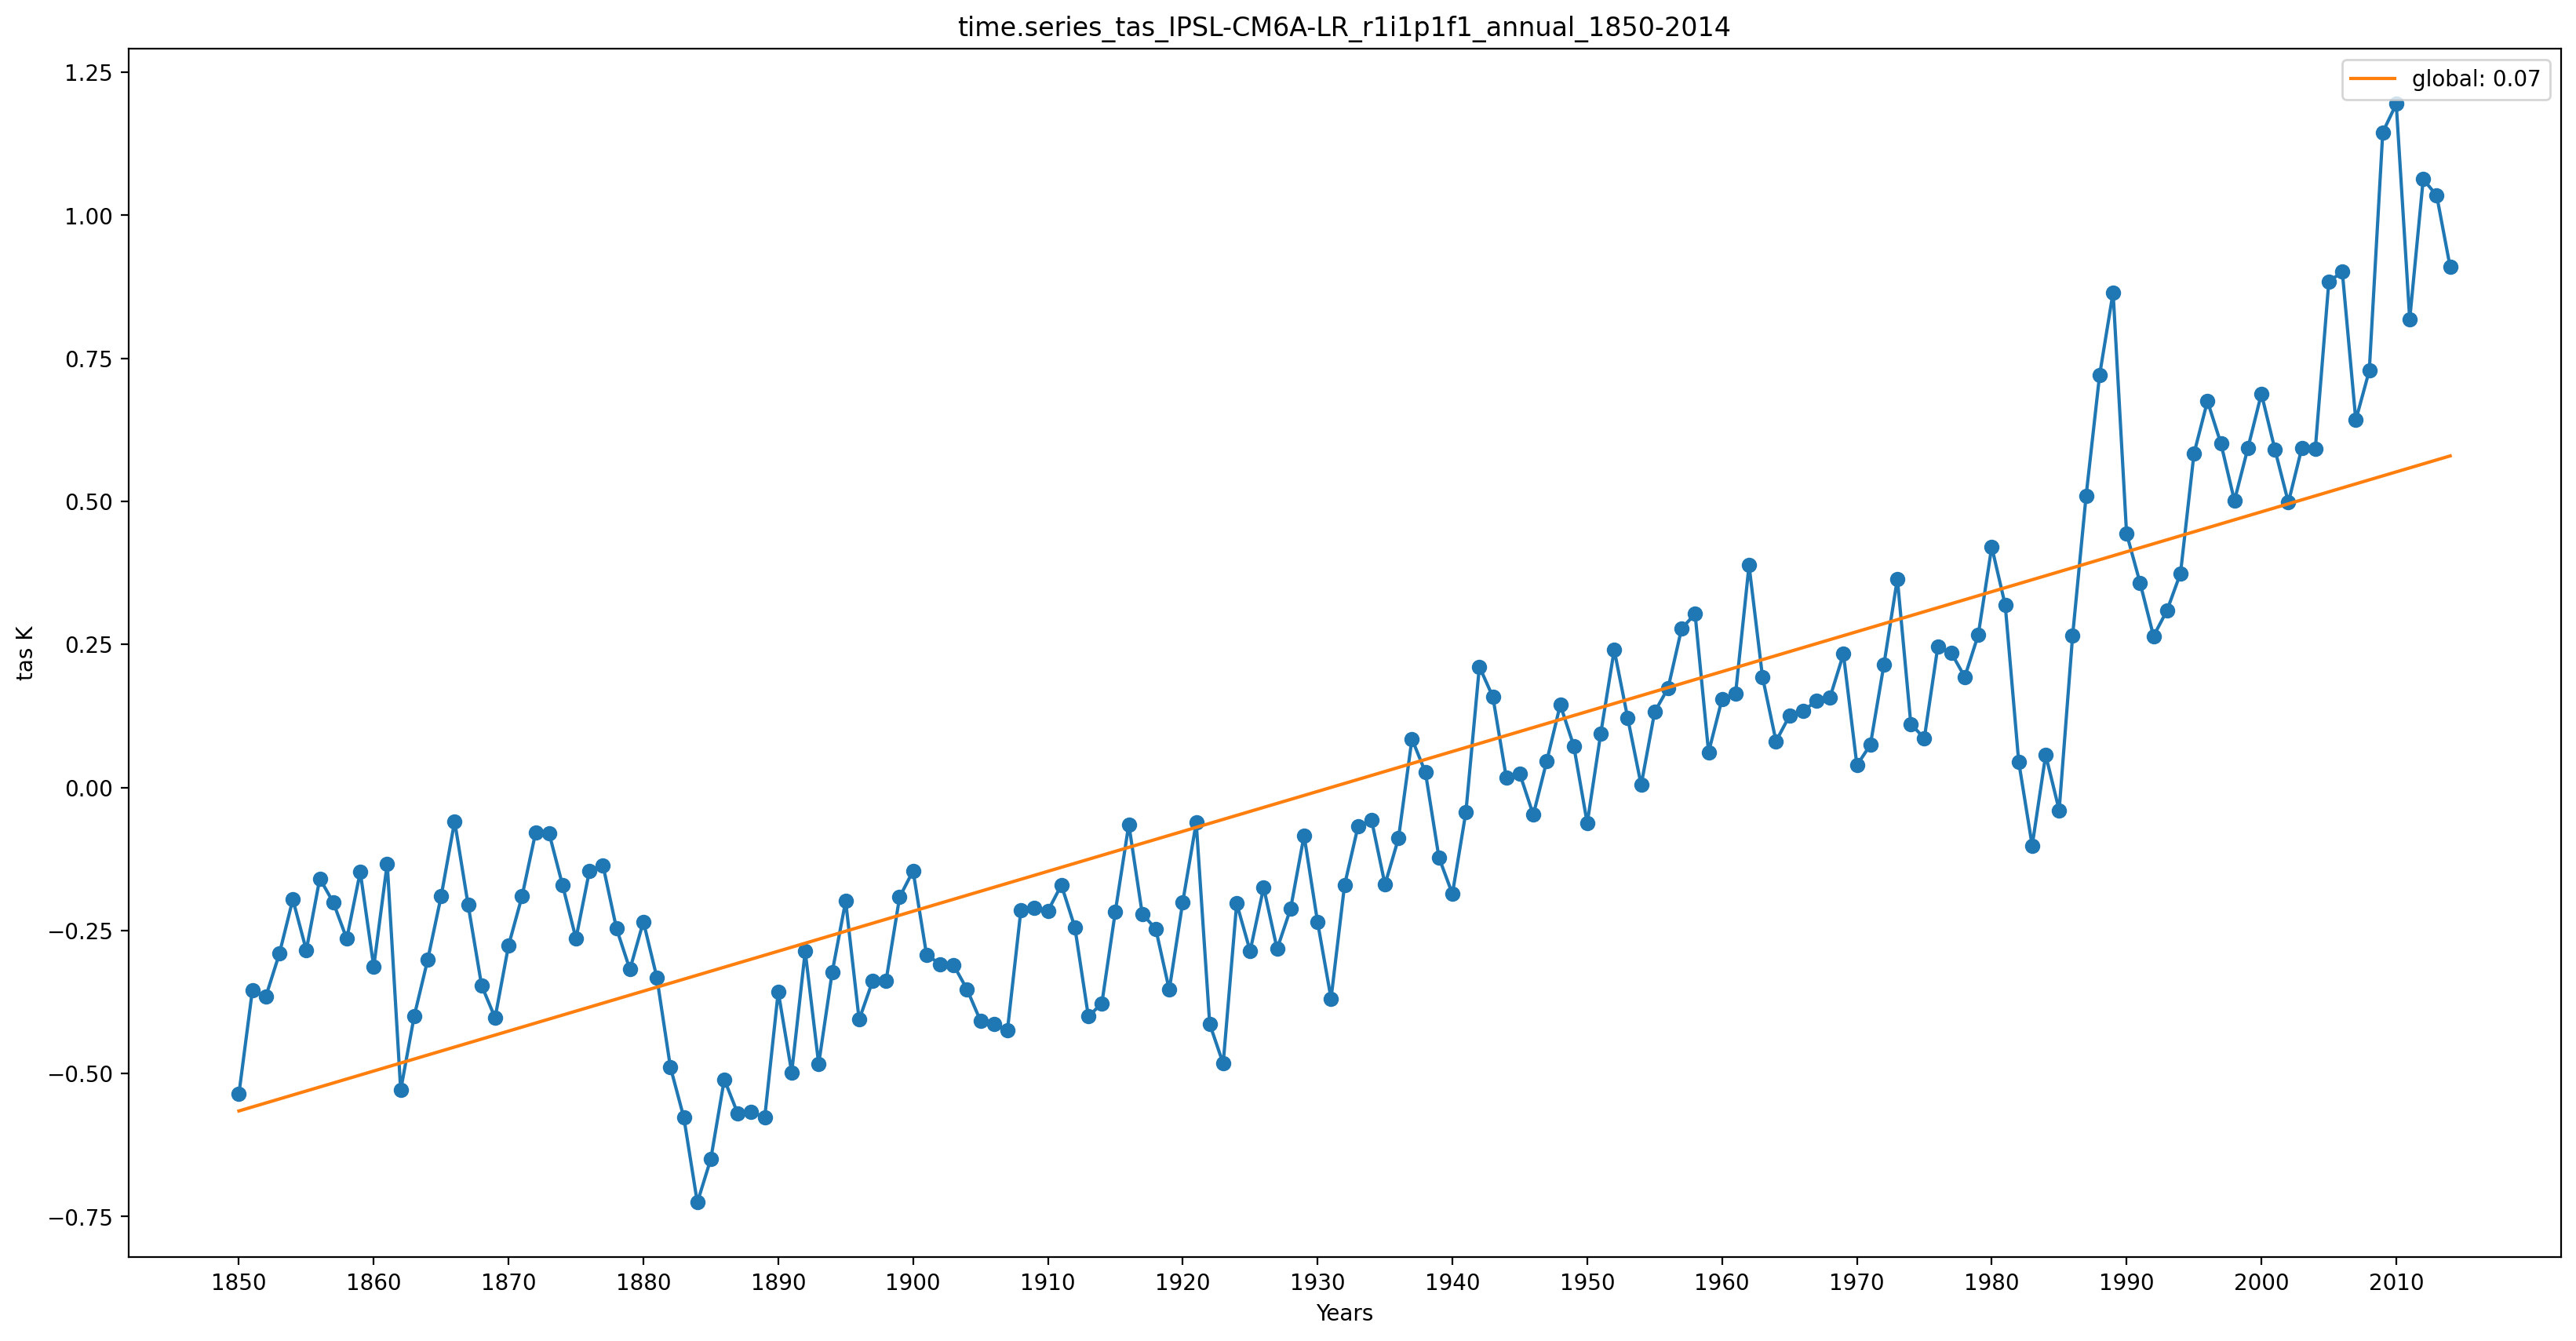

In [24]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s %s'%(variable,units))
plt.xlabel('Years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o')
#plt.plot(xdplot,trend*xdplot+intercept,label='t: %1.2f +- err:%1.2f'%(10*trend,10*stderr))
plt.plot(xdplot,trend*xdplot+intercept,label='global'+': %1.2f'%(10*trend))
plt.legend()
#plotname='time_series_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plotname='time.series_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,iyr,fyr)
plt.title(plotname,fontsize=12)
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [25]:
domain='EuroMed'
xi=70;xf=89
xlon_dom=xlon[xi:xf]
nlon_dom=len(xlon_dom)
yi=92;yf=110
ylat_dom=ylat[yi:yf]
nlat_dom=len(ylat_dom)

#value_dom=value[:,yi:yf,xi:xf,:]
anom_dom=anom[:,yi:yf,xi:xf]
#anom_notrend_dom=anom_notrend[:,yi:yf,xi:xf]

wgts = np.cos(np.deg2rad(ylat_dom))

ts_anoms_dom=np.ma.average(np.ma.average(anom_dom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
#ts_anoms_notrend_dom=np.ma.average(np.ma.average(anom_notrend_dom,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)
#
#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par_dom = stats.linregress(xd,ts_anoms_dom)
trend_dom=par_dom[0]
intercept_dom=par_dom[1]
#rvalue_dom=par_dom[2]
#pvalue_dom=par_dom[3]
#stderr_dom=par_dom[4]

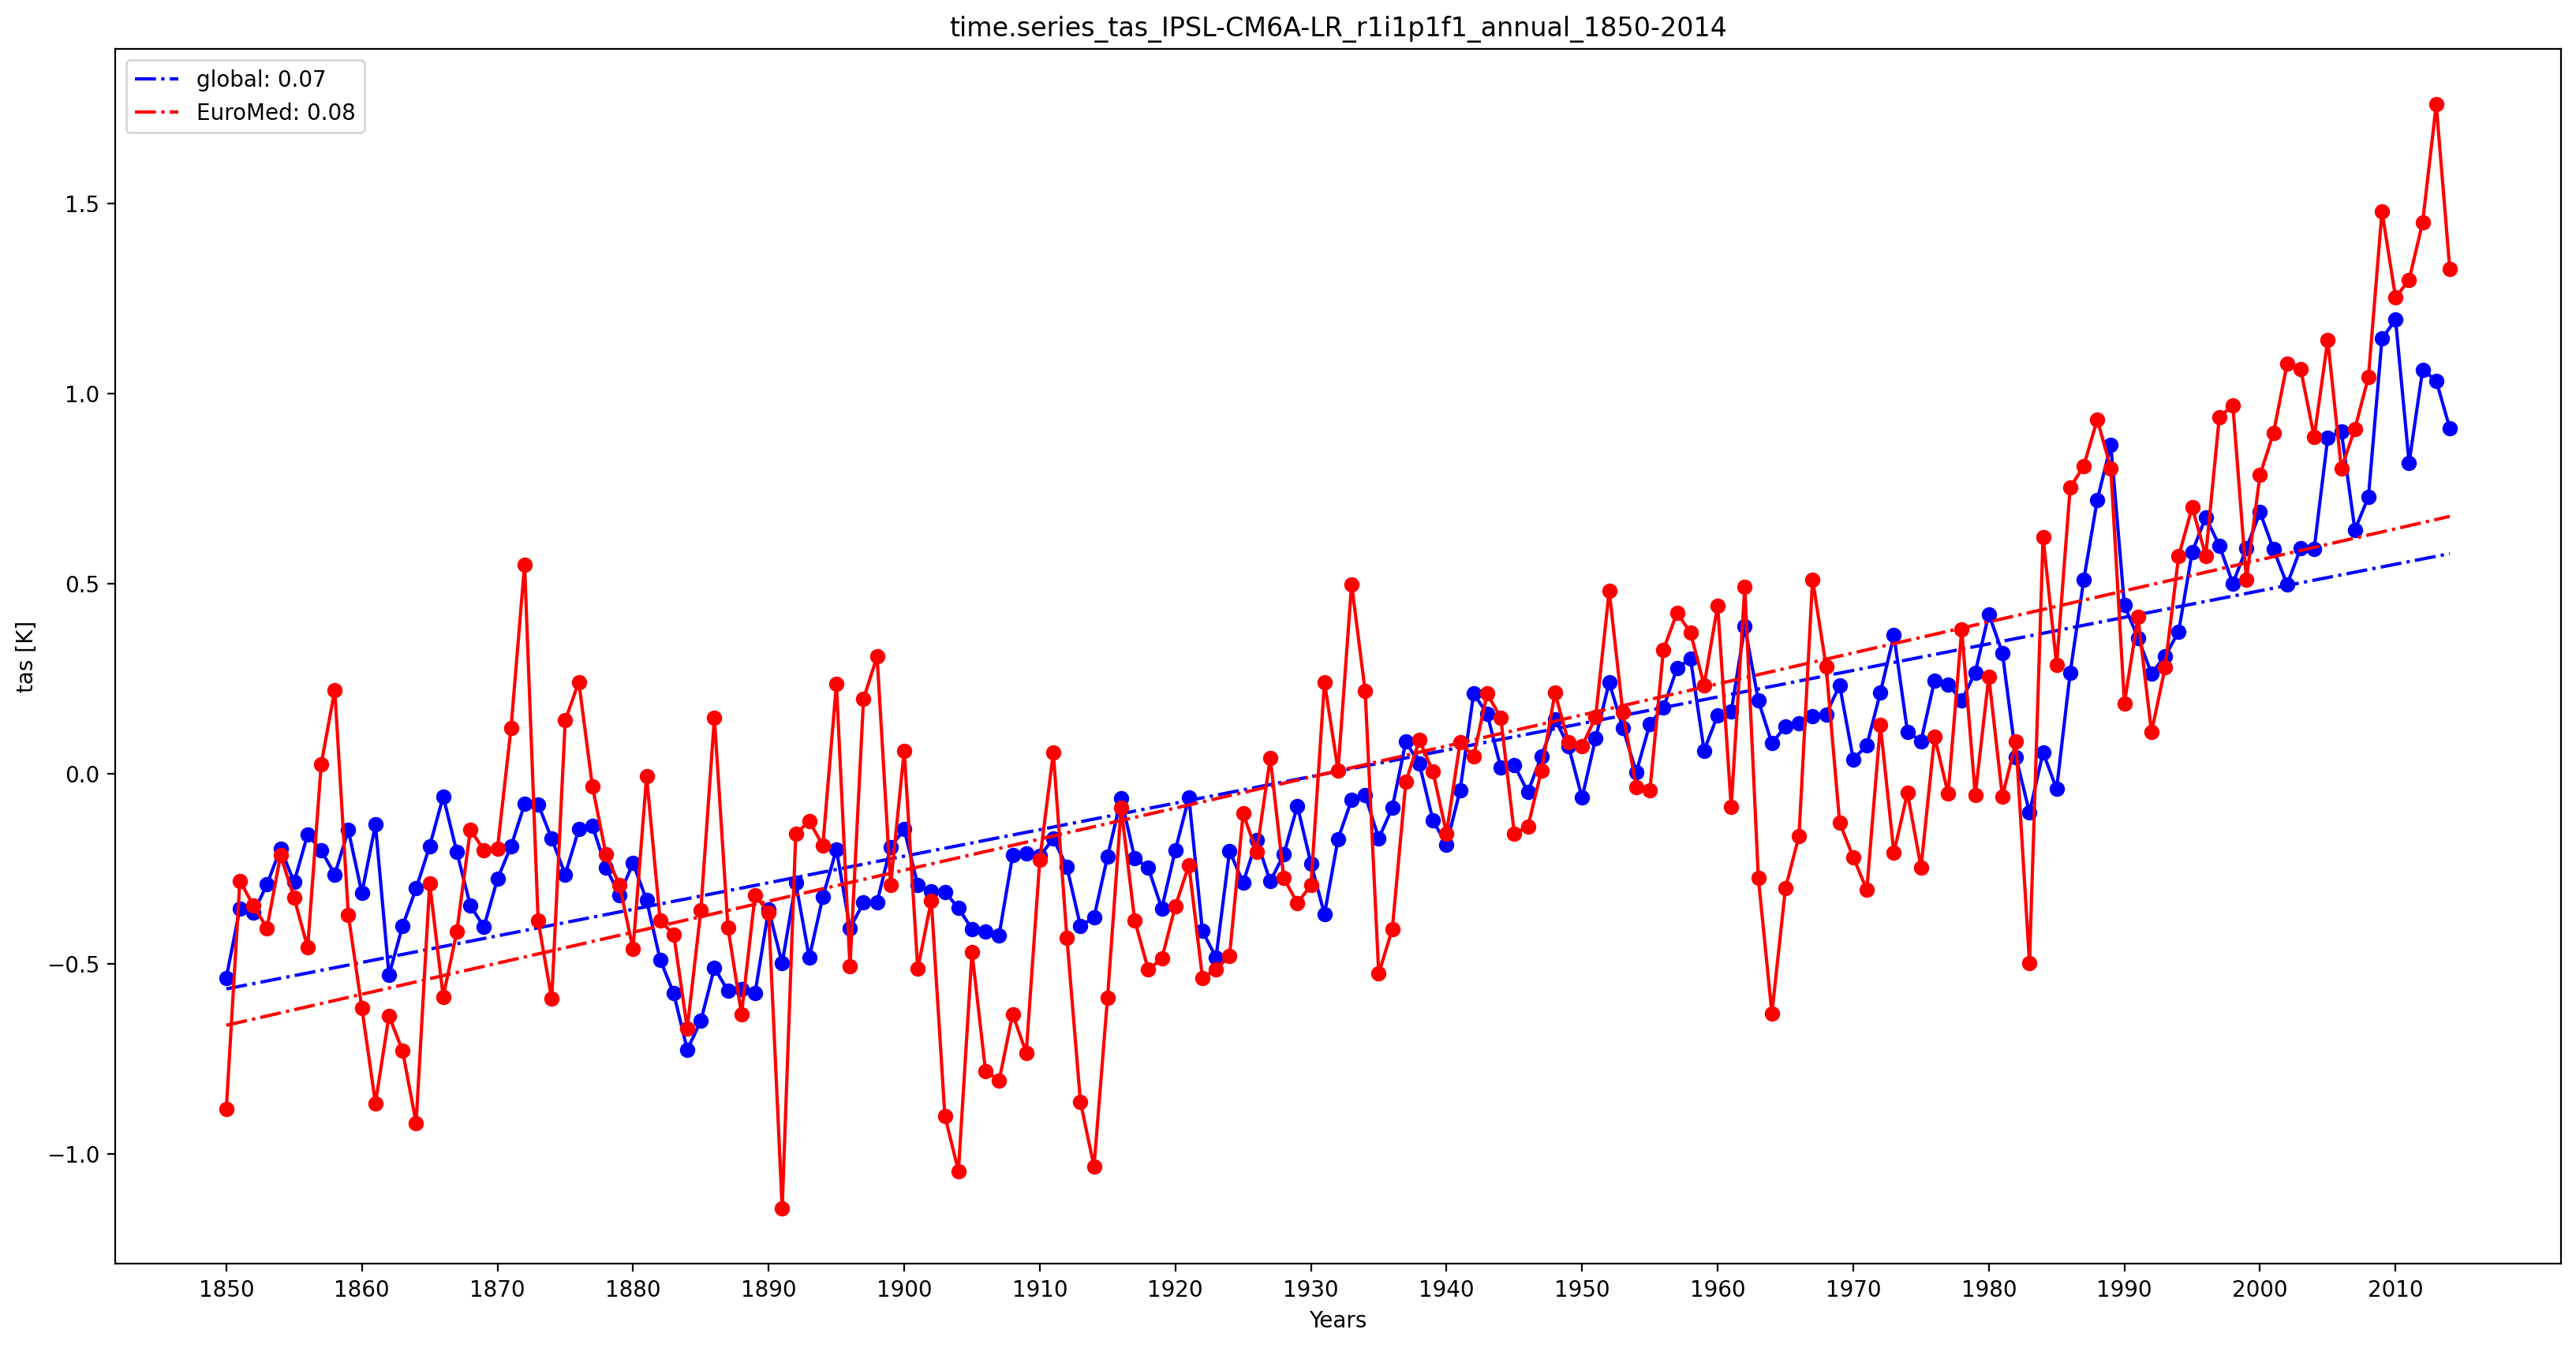

In [26]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s [%s]'%(variable,units))
plt.xlabel('Years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.title(plotname,fontsize=12)
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o',color='blue')
#plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f +- %1.2f'%(10*trend,10*stderr))
plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f'%(10*trend))

plt.plot(xdplot,ts_anoms_dom,linestyle='-',marker='o',color='red')
#plt.plot(xdplot,trend_dom*xdplot+intercept,linestyle='-.',color='red',label=domain+': %1.2f +- %1.2f'%(10*trend_dom,10*stderr_dom))
plt.plot(xdplot,trend_dom*xdplot+intercept_dom,linestyle='-.',color='red',label=domain+': %1.2f'%(10*trend_dom))
plt.legend()

plotname='time.series_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,iyr,fyr)
plt.title(plotname,fontsize=12)
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [27]:
domain='BCN'
ts_anoms_dom=anom[:,103,73]
#ts_anoms_notrend_dom=anom_notrend[:,103,73]

#wgts = np.cos(np.deg2rad(ylat_dom))

#ts_anoms_dom=np.ma.average(np.ma.average(anom_dom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
#ts_anoms_notrend_dom=np.ma.average(np.ma.average(anom_notrend_dom,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)
#
#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par_dom = stats.linregress(xd,ts_anoms_dom)
trend_dom=par_dom[0]
intercept_dom=par_dom[1]
#rvalue_dom=par_dom[2]
#pvalue_dom=par_dom[3]
#stderr_dom=par_dom[4]

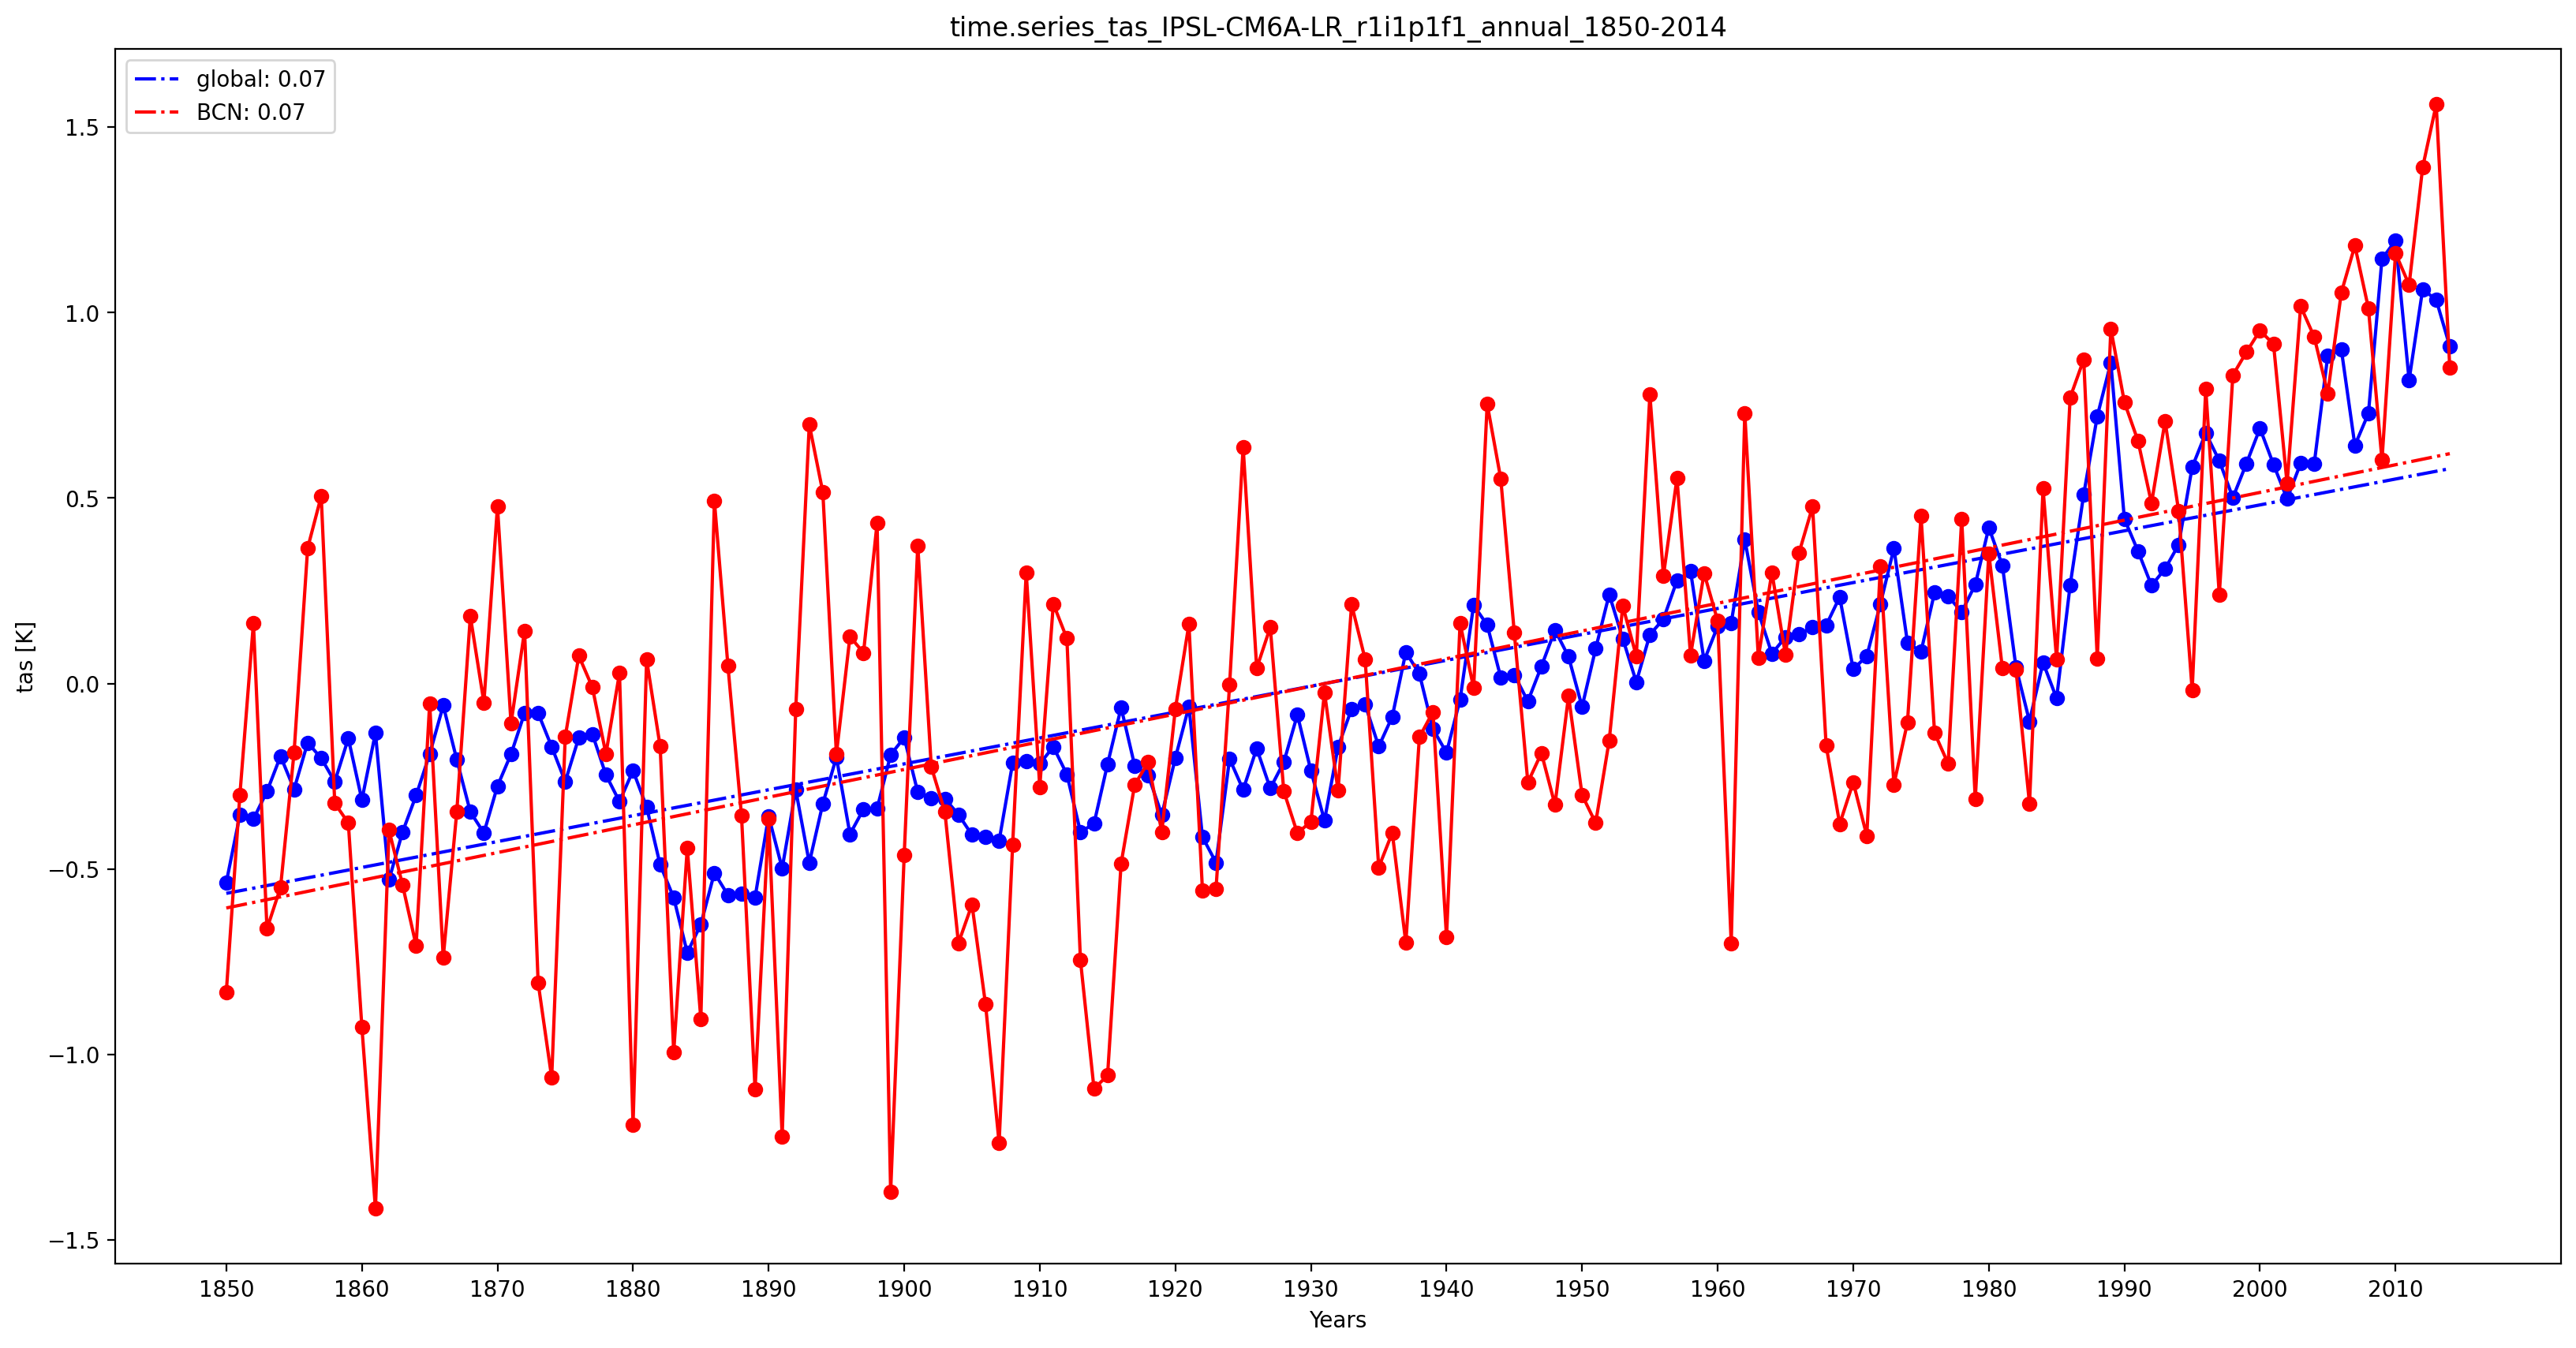

In [28]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s [%s]'%(variable,units))
plt.xlabel('Years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.title(plotname,fontsize=12)
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o',color='blue')
#plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f +- %1.2f'%(10*trend,10*stderr))
plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f'%(10*trend))

plt.plot(xdplot,ts_anoms_dom,linestyle='-',marker='o',color='red')
#plt.plot(xdplot,trend_dom*xdplot+intercept,linestyle='-.',color='red',label=domain+': %1.2f +- %1.2f'%(10*trend_dom,10*stderr_dom))
plt.plot(xdplot,trend_dom*xdplot+intercept_dom,linestyle='-.',color='red',label=domain+': %1.2f'%(10*trend_dom))
plt.legend()

plotname='time.series_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,iyr,fyr)
plt.title(plotname,fontsize=12)
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()